In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from matplotlib import rcParams
from cycler import cycler

from utils import *
from plot_utils import *
from AnalyseDefects import AnalyseDefects

## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue', 'firebrick', 'darkorange', 'darkviolet', 'darkgoldenrod', 'darkslategray', 'darkturquoise',\
             'darkmagenta', 'darkkhaki', 'darkolivegreen', 'darkseagreen', 'darkslateblue', 'darkslategrey', 'darkorchid', 'darkcyan', 'darkred', 'darkgray', 'darkgreen'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [ ]:
LX = [256, 512, 1024, 2048]
prefix = ""
for L in LX:
    path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{L}_LL0.05{prefix}_sfac'
    if os.path.isdir(path):
        print(L)
        move_files(path)

In [2]:
LL = 1024
mode = 'all'
output_path = f'data\\nematic_analysis{LL}_LL0.05'

dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
             suffix = "long", priority = 0, LX = LL, Nframes = 400)
dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                   suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                   suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)

if mode == 'all':
    if LL == 2048:
        defect_list = [dshort, dlong]
    else:
        defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
else:
    defect_list = [dshort]

def log_func(x, a, b, c):
    return a * np.log(x) + b*x + c
fit_string = rf'$y = a \ln x + bx + c $'
fit_dict = dict(fit_func = log_func, fit_string = fit_string, lower_act_index = 12, param_guess = np.array([0.005, 0.04,0.015]))

ad = AnalyseDefects(defect_list, output_path=output_path)


In [3]:
# Extract, analyze and merge results
ad.extract_results()
ad.analyze_defects()
ad.merge_results()

Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis1024_LL0.05
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis1024_LL0.05_long
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis1024_LL0.05_very_long
NB: All simulations are set to converge at the first frame for dataset 0. To change this, call update_conv_list.



In [3]:
Bs, Xs = ad.get_binder_susceptibility(use_merged = True)
acts = ad.act_list[0]

In [5]:
Bn, Xn = ad.get_binder_susceptibility(use_merged = True)
acts = ad.act_list[0]

In [11]:
def_arr = ad.get_arrays_full(Ndataset = 2)[0]
av_def = ad.get_arrays_av(Ndataset = 2)[-1]  

In [12]:
def_arr_shifted = np.nanmean((def_arr - av_def[:,0][None,:,None])**4, axis = -1) \
/ np.nanmean((def_arr - av_def[:,0][None,:,None])**2, axis = -1) ** 2
def_arr_non = np.nanmean((def_arr)**4, axis = -1) \
/ np.nanmean((def_arr)**2, axis = -1) ** 2
act_list = ad.act_list[2]
conv_list = ad.conv_list[2]

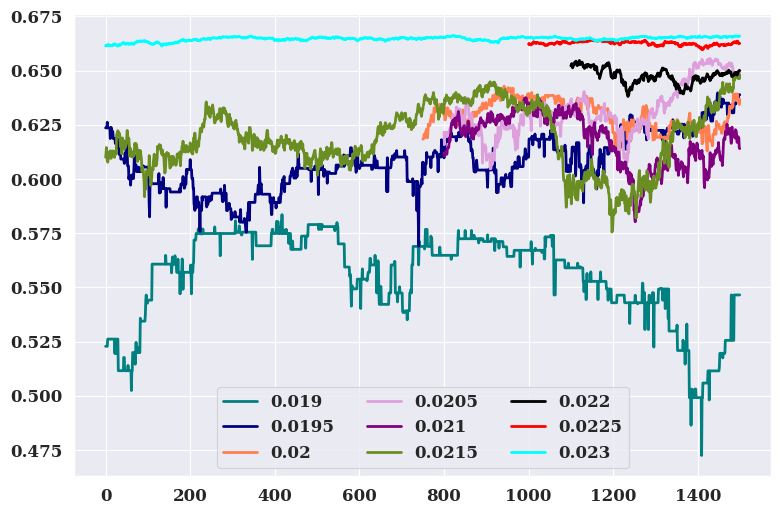

In [59]:
for i, act in enumerate(act_list):
    plt.plot(np.arange(conv_list[i], def_arr_non.shape[0]), 1 - def_arr_non[conv_list[i]:,i]/3, label = f'{act}')
plt.legend(fontsize=12, ncol=3)

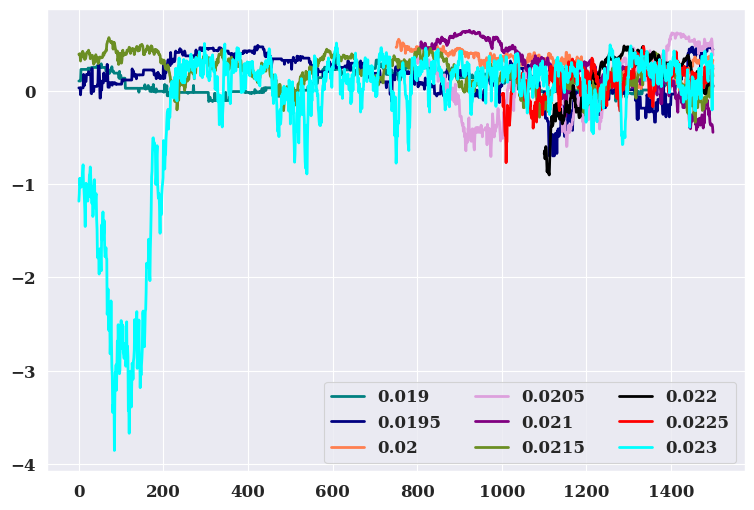

In [53]:
for i, act in enumerate(act_list):
    plt.plot(np.arange(conv_list[i], def_arr_shifted.shape[0]), 1 - def_arr_shifted[conv_list[i]:,i]/3, label = f'{act}')
plt.legend(fontsize=12, ncol=3)

In [76]:
def_arr_shifted = np.nanmean((def_arr - av_def[:,0][None,:,None])**4, axis = -1) \
/ np.nanmean((def_arr - av_def[:,0][None,:,None])**2, axis = -1) ** 2
def_arr_non = np.nanmean((def_arr)**4, axis = -1) \
/ np.nanmean((def_arr)**2, axis = -1) ** 2
def_arr_a_non = np.nanmean((def_arr_a)**4, axis = -1) \
/ np.nanmean((def_arr_a)**2, axis = -1) ** 2

In [75]:
A = np.pi * 1.25 ** 2
LLX = 1024
def_arr_a = (2  * A * def_arr - LLX ** 2) / (LLX ** 2)

In [23]:
def_arr_a.shape

(1500, 9)

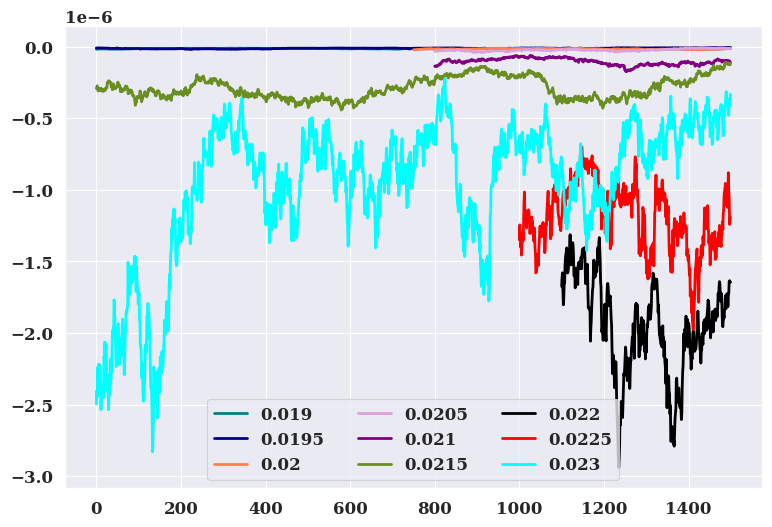

In [77]:
for i, act in enumerate(act_list):
    plt.plot(np.arange(conv_list[i], def_arr_a_non.shape[0]), 1 - def_arr_a_non[conv_list[i]:,i], label = f'{act}')
plt.legend(fontsize=12, ncol=3)

In [42]:
avs_a

[1.0000000140844199,
 1.0000000122675108,
 1.0000000167279066,
 1.000000024199678,
 1.0000001046177847,
 1.0000002898864289,
 1.0000019527332868,
 1.0000011906074915,
 1.0000009691413927]

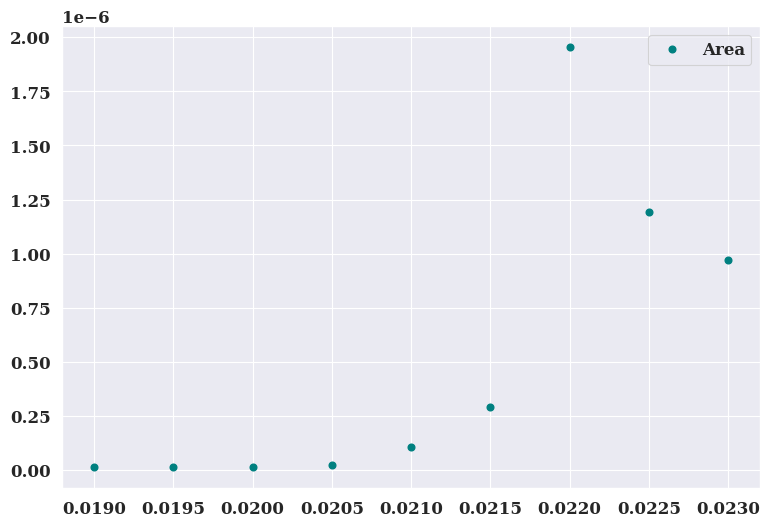

In [80]:
fig, ax = plt.subplots()
avs = []
avs_un = []
avs_a = []
for i, act in enumerate(act_list):
    avs.append(1 - np.nanmean(def_arr_shifted[conv_list[i]:,i]))
    avs_un.append(1 - np.nanmean( def_arr_non[conv_list[i]:,i]))
    avs_a.append(-1 + np.nanmean(def_arr_a_non[conv_list[i]:,i]))


#ax.plot(act_list, avs, 'o', label = 'Shifted')
#ax.plot(act_list, avs_un, 'o', label = 'Unshifted')
ax.plot(act_list,avs_a, 'o', label = 'Area')
plt.legend(fontsize=12, ncol=3)
#ax.set_ylim(0.9995,1.0005)

(0.016, 0.04)

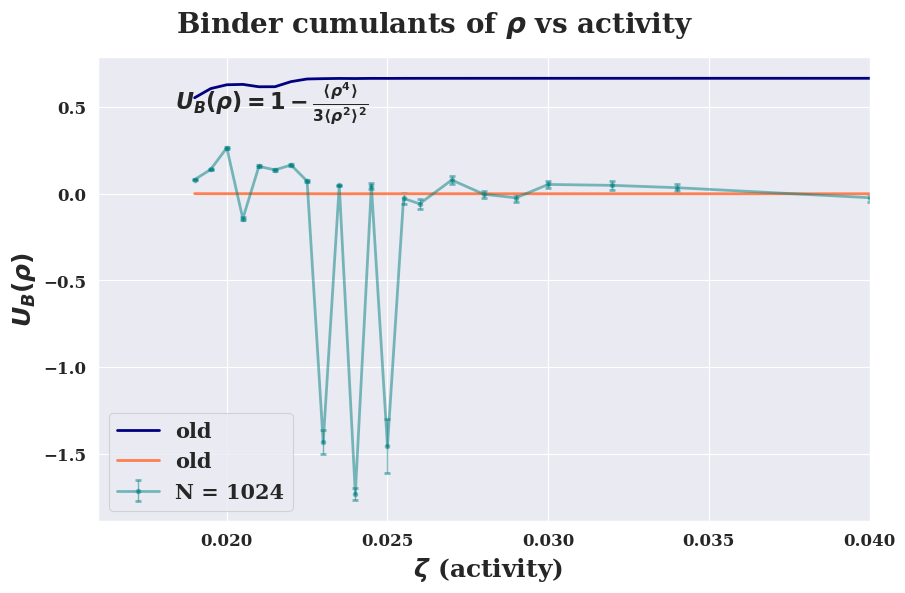

In [10]:
fig, ax = ad.plot_binder_cumulants(plot_binder = True, use_merged = True)
ax.plot(acts,Bs, label = 'old')
ax.legend()
ax.set_xlim(0.016,0.04)

In [8]:
Y = np.ones([2,3,4])
x = np.linspace(1,6,6).reshape(-1,2)
Y/x[:,0][None, :, None]

array([[[1.     , 1.     , 1.     , 1.     ],
        [0.33333, 0.33333, 0.33333, 0.33333],
        [0.2    , 0.2    , 0.2    , 0.2    ]],

       [[1.     , 1.     , 1.     , 1.     ],
        [0.33333, 0.33333, 0.33333, 0.33333],
        [0.2    , 0.2    , 0.2    , 0.2    ]]])

In [3]:
act_idx_bounds=[0,None]
use_merged = True
Npoints_to_fit = 5

In [ ]:
fig, ax = ad.plot_density_fluctuation_time_av(Ndataset = 0, \
                                    act_idx_bounds = [4,None], window_idx_bounds = [14, None], use_merged = True, save = True)

window_sizes = ad.window_sizes[0][14:]
min_val = 0.04
ax.plot(window_sizes, (min_val * window_sizes[0] ** 2) / window_sizes ** 2, '--', color='black', alpha=0.7, lw = 1.7)
ax.text(0.03, 0.45, r'$\sim R^{-2}$', fontsize=15, transform=ax.transAxes, verticalalignment='top', fontweight='normal')

ax.plot(window_sizes, 13000/ window_sizes ** 3, '--', color='black', alpha=0.7, lw = 1.7)
ax.text(0.15, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')

ax.set_ylim(bottom = 5e-4, top = .1)

output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
#fig.savefig(os.path.join(output_path, f'figs\\dens_fluc_time_av.png'), dpi = 420, pad_inches=0.25)


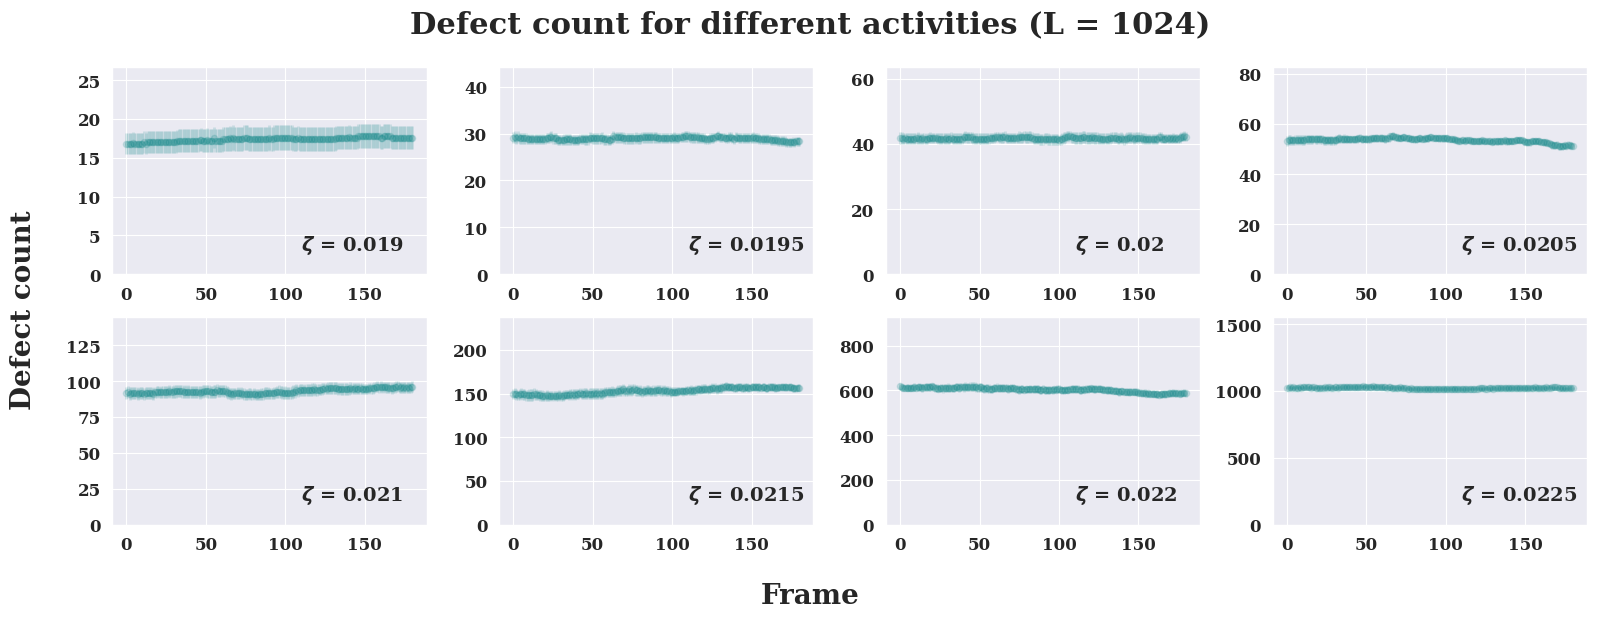

In [30]:
# check that conv_list is good for each dataset
act_min_idx = 0
fig, ax = ad.plot_defects_per_activity(Ndataset=0, act_min_idx = act_min_idx, act_max_idx = act_min_idx + 8, use_merged=use_merged, save=False)


Non-converged fits (p < 0.05):  0


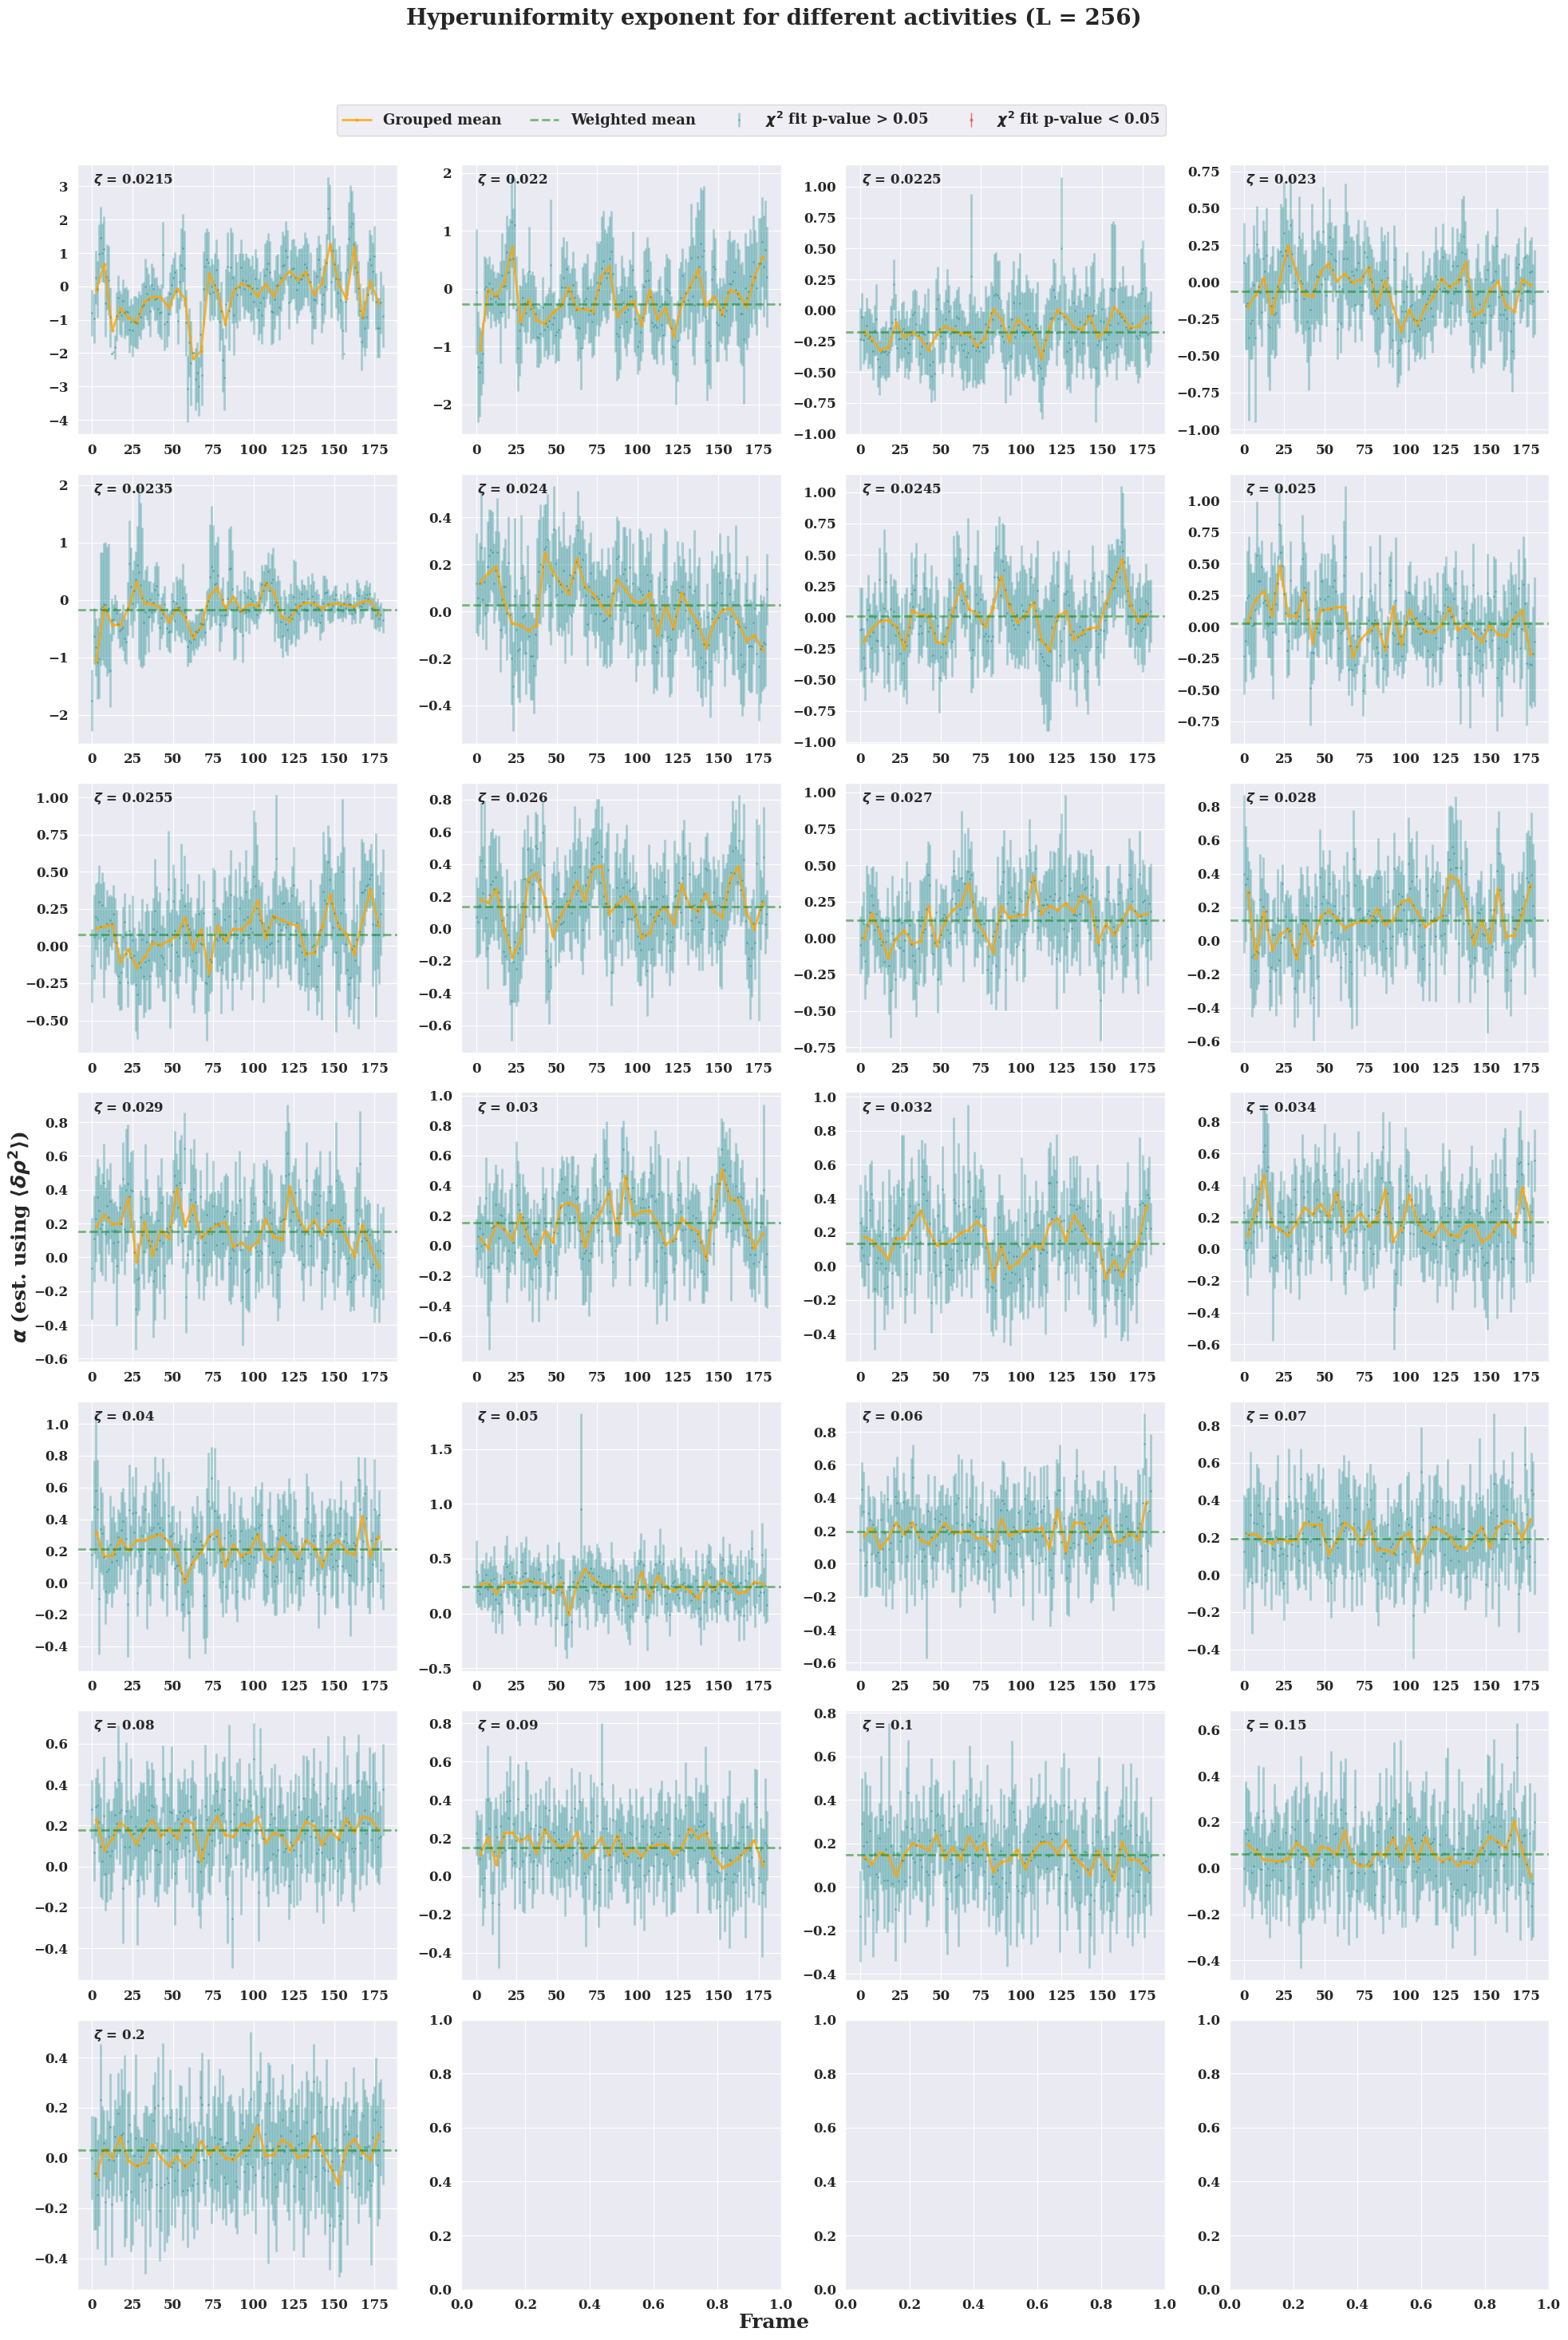

In [195]:
fitp_dens, statp_dens = ad.analyze_hyperuniformity(Ndataset = 3, fit_densities=True, save = True, \
                    weighted_mean = False, plot = True, use_merged = use_merged,\
                     act_idx_bounds=act_idx_bounds, window_idx_bounds=[30 - Npoints_to_fit, None]);


In [ ]:
#fig, ax = ad.plot_alpha_mean(Ndataset = 0, include=['fluc', 'sfac_time_av', 'sfac_time_av_unweighted'], use_merged = use_merged, save = True);
fig, ax = ad.plot_alpha_mean(Ndataset = 3, include=['fluc'],\
             use_merged = use_merged, save = False,);
ax.set_ylim(bottom = -.65, top=.38)
ax.set_xlim(left = 0.019, right=.03)
ax.legend(ncol=1, loc = 'lower right')
output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
fig_name = 'alpha_mean_transition.png'
#fig.savefig(os.path.join(output_path, f'figs\\{fig_name}'), dpi = 420, pad_inches=0.25)

UnboundLocalError: local variable 'act_list_fluc' referenced before assignment

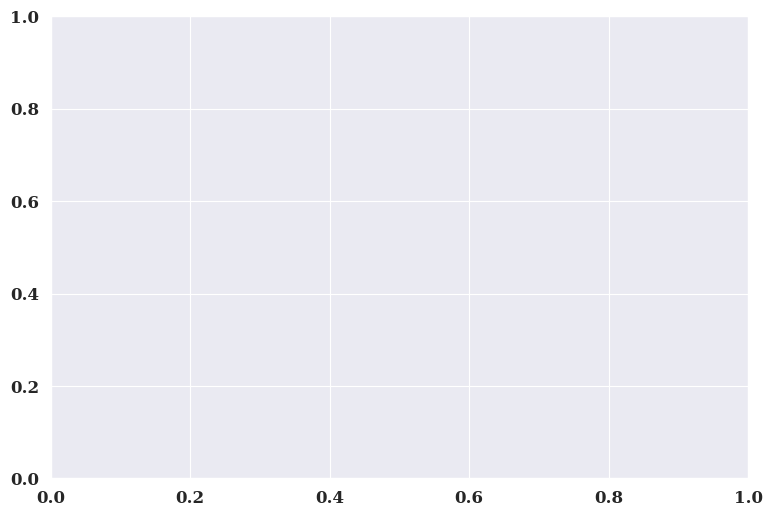

In [8]:
#fig, ax = ad.plot_alpha_mean(Ndataset = 0, include=['fluc', 'sfac_time_av', 'sfac_time_av_unweighted'], use_merged = use_merged, save = True);
fig, ax = ad.plot_alpha_mean(Ndataset = 0, include=['all'],\
             use_merged = use_merged, save = True,);
ax.set_ylim(bottom = -.65, top=.38)
ax.set_xlim(left = 0.019, right=.03)
ax.legend(ncol=1, loc = 'lower right')
output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
fig_name = 'alpha_mean_transition.png'
#fig.savefig(os.path.join(output_path, f'figs\\{fig_name}'), dpi = 420, pad_inches=0.25)


In [ ]:
Nbounds = [3,7]

fitp = ad.analyze_sfac_time_av(Ndataset=3,Npoints_bounds = Nbounds, weighted = False, act_idx_bounds=act_idx_bounds, use_merged = use_merged,save = True, plot = False);
ad.analyze_sfac_time_av(Ndataset=3,Npoints_bounds = Nbounds, weighted = True, act_idx_bounds=act_idx_bounds, use_merged = use_merged, save = True, plot = False,);
#fitpp = ad.analyze_sfac2(Ndataset=0, Npoints_bounds = Nbounds, weighted = True, act_idx_bounds = act_idx_bounds, use_merged = use_merged, save = True, plot = False);
#ad.analyze_sfac2(Ndataset=0, Npoints_bounds = Nbounds, weighted = False, act_idx_bounds = act_idx_bounds, use_merged = use_merged, save = True, plot = False);
ad.plot_alpha_mean(Ndataset = 3, include=['fluc', 'sfac_time_av', 'sfac_time_av_unweighted'], use_merged = use_merged, save = True);

Non-converged fits (p < 0.01):  3086
Non-converged fits (p < 0.01):  212


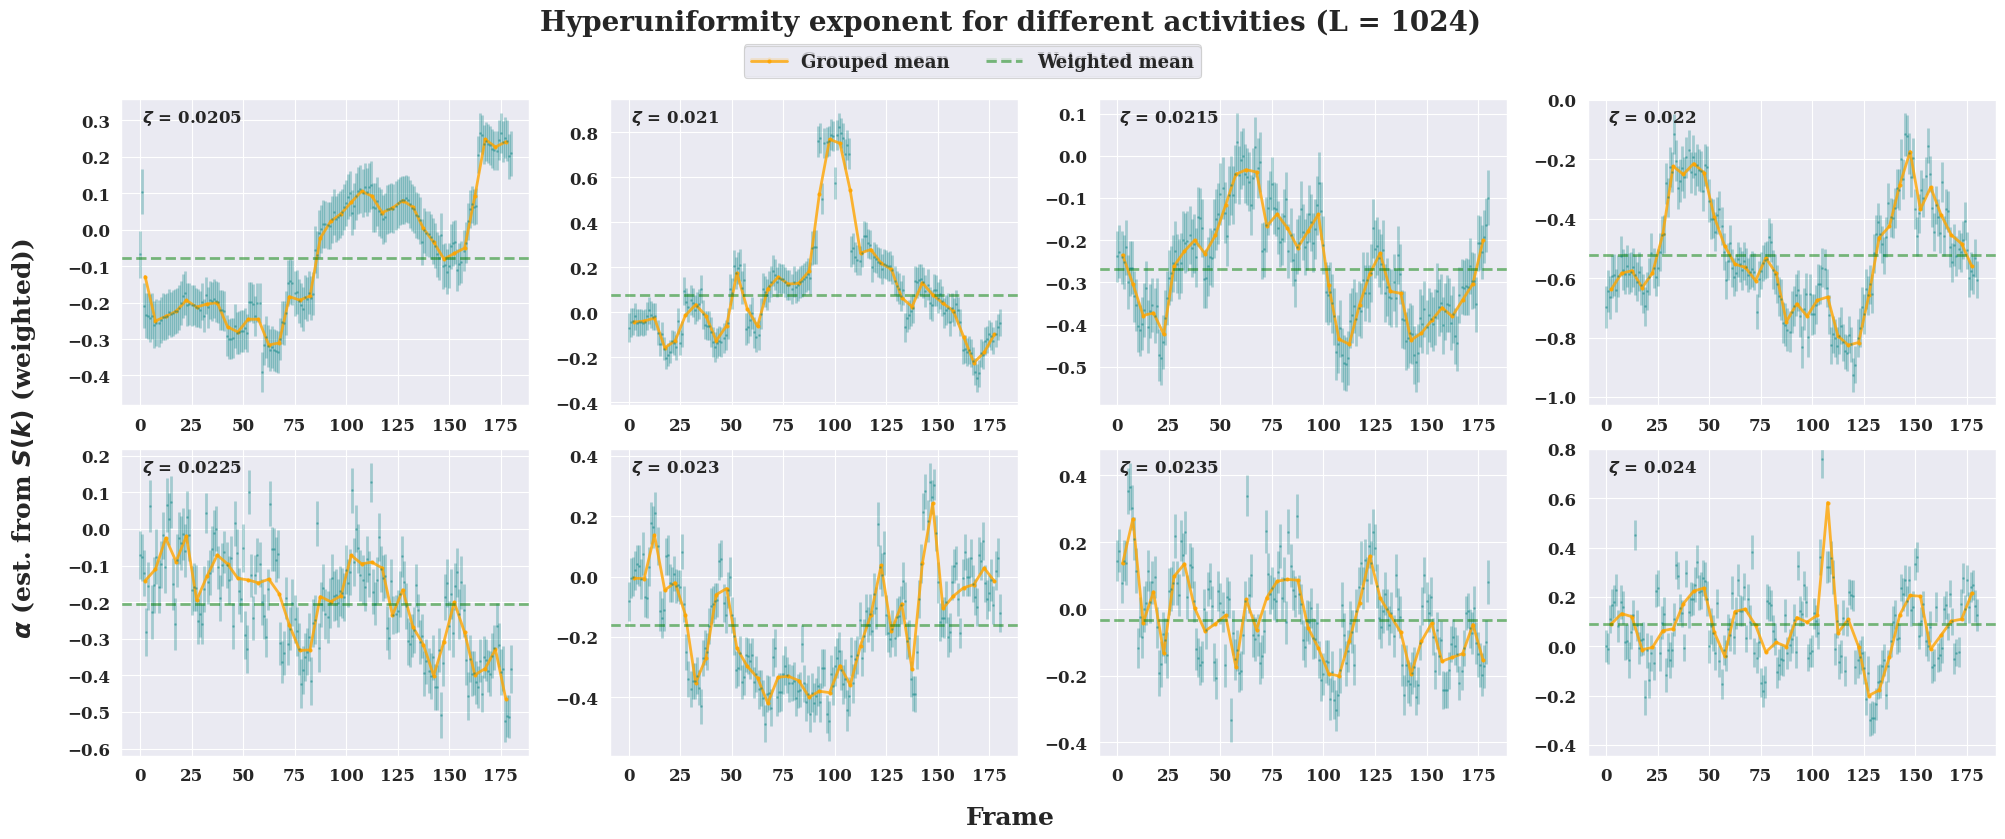

In [262]:
Npoints_to_fit = 5
act_idx_min = 3
fitpp = ad.analyze_sfac(Ndataset=0, Npoints_to_fit = Npoints_to_fit, weighted = True, act_idx_bounds = act_idx_bounds, use_merged = use_merged, save = True, plot = False);
ad.analyze_sfac(Ndataset=0, Npoints_to_fit = Npoints_to_fit, weighted = False, act_idx_bounds = act_idx_bounds, use_merged = use_merged, save = True, plot = False);
fig, ax = ad.plot_hyperuniformity_sfac(act_idx_bounds=[act_idx_min,act_idx_min + 8], use_merged = True, weighted = True, save = True)

output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
fig_name = 'alpha_sfac.png'
fig.legend(ncol=4, fontsize = 13,bbox_to_anchor=(0.6, 1.00))
fig.supylabel(rf'$\alpha$ (est. from $S(k)$ (weighted))', x = 0.0)
fig.suptitle(f'Hyperuniformity exponent for different activities (L = {LL})', y=1.035)
fig.savefig(os.path.join(output_path, f'figs\\{fig_name}'), dpi = 420, pad_inches=0.1)
ax[-1].set_ylim(top = .8)
plt.show()

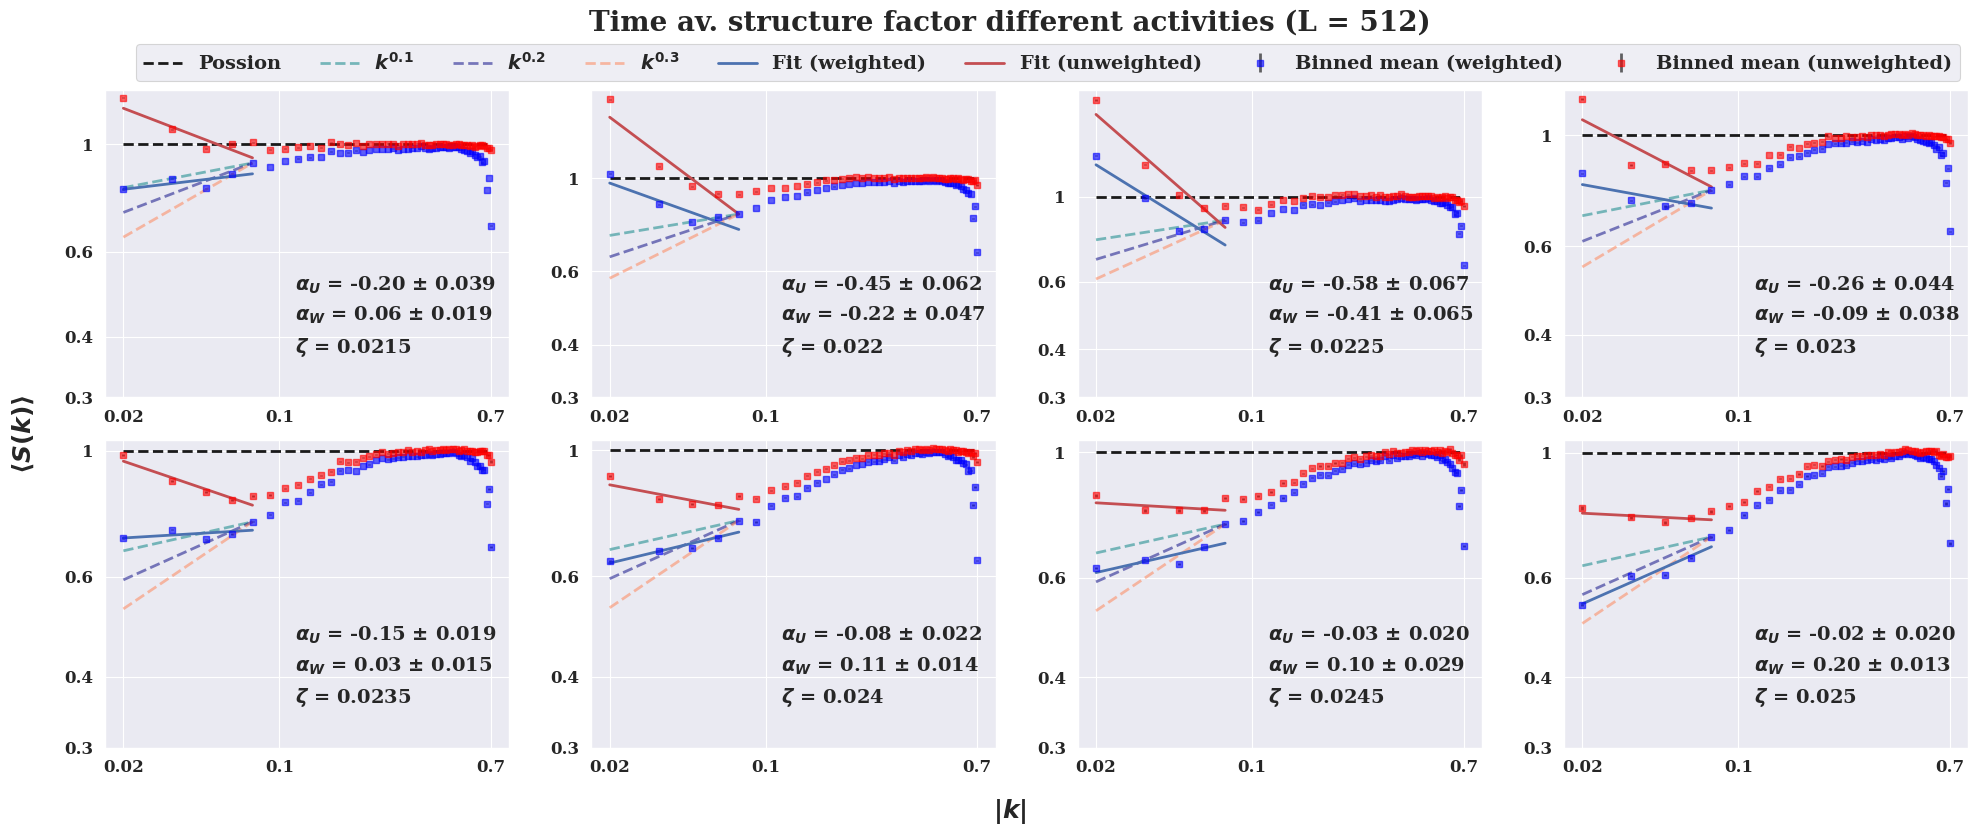

In [18]:
act_idx_min = 6
fig, ax = ad.plot_sfac_weighted_vs_unweighted(Npoints_to_fit=5, act_idx_bounds=[act_idx_min,act_idx_min+8], use_merged=use_merged, save = False)

(0.0, 2.0)

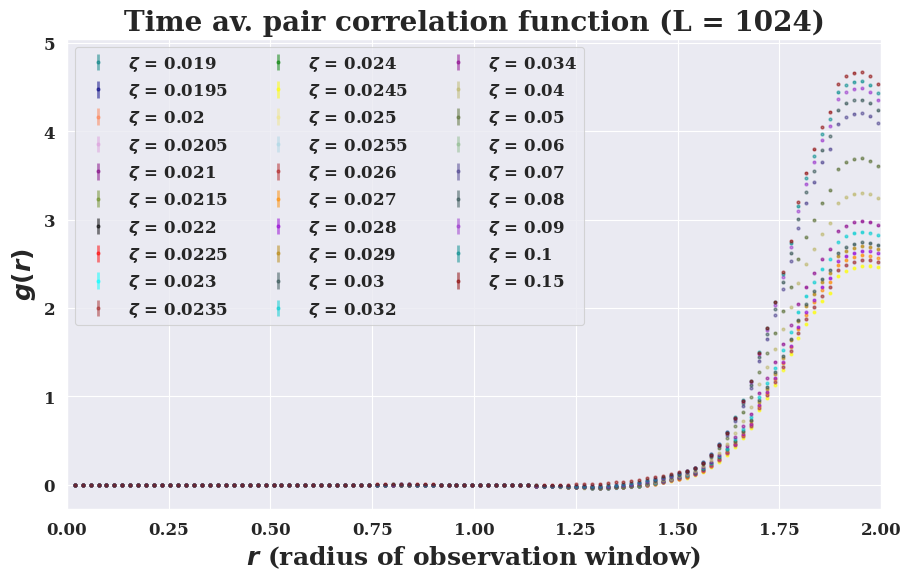

In [7]:
fig, ax = ad.plot_pair_corr_function_time_av(act_idx_bounds=[0,-1], use_merged=use_merged, save = True)
ax.legend(fontsize=12,ncol=3)
output_path = os.path.join(ad.output_main_path, 'merged_results')
#fig.savefig(os.path.join(output_path, f'figs\\pcf.png'), dpi = 420, pad_inches=0.25)
ax.set_xlim(left = 0, right = 2)

No. of windows with max susceptibility at activity 0.022: 22


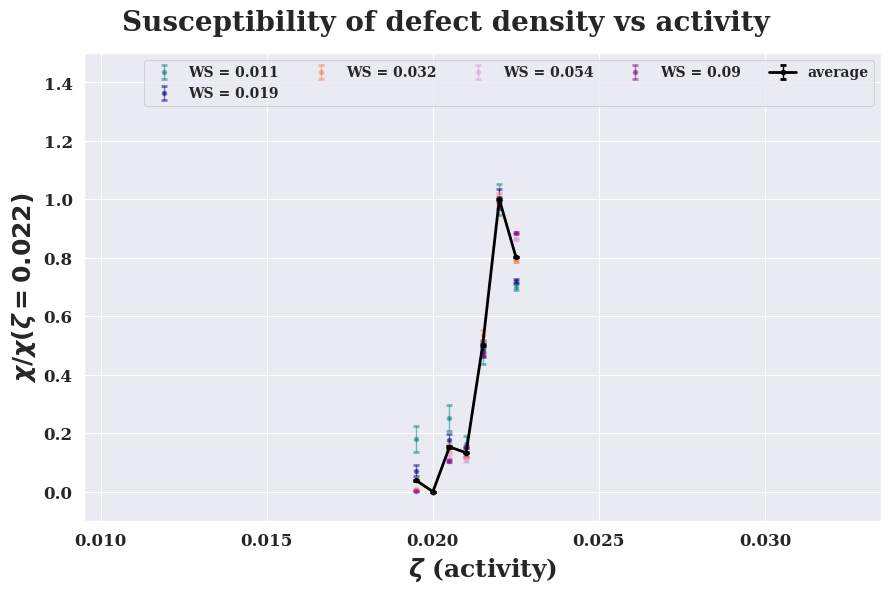

In [39]:
fig, ax = ad.plot_susceptibility(Ndataset=3,Nwindows_jump=5, act_max = 0.022, use_merged=use_merged, act_idx_bounds=[0,None], window_idx_bounds=[8,None])


(<Figure size 900x600 with 1 Axes>,
 <Axes: xlabel=' $\\zeta$ (activity)', ylabel='$U(\\rho)$'>)

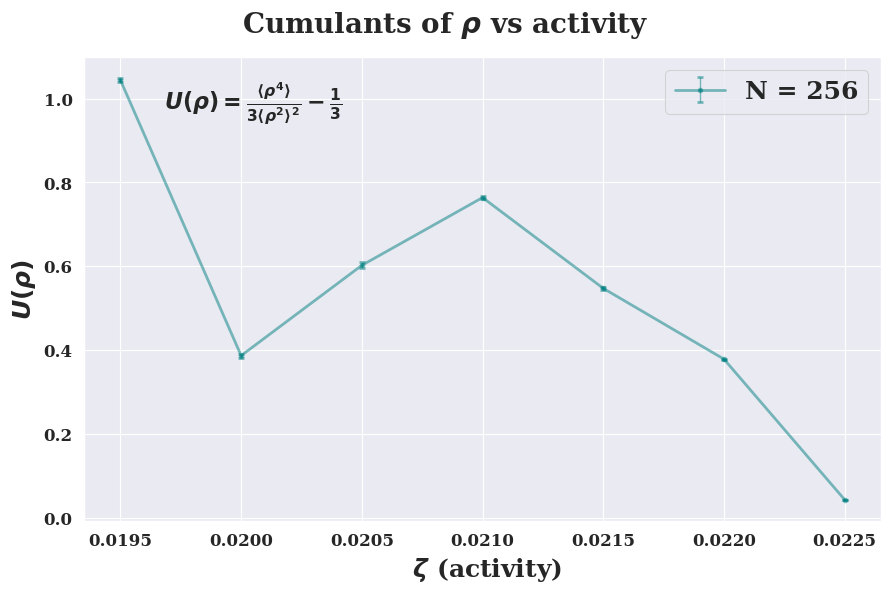

In [41]:
ad.plot_binder_cumulants(Ndataset=3, act_idx_bounds=[0,None], use_merged=use_merged,)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 6))
minn = 0
maxx = None
window_idx_bounds_list=[[minn, maxx], [minn, 20], [minn, 15], [20, maxx], [20, None], [10, maxx], [10, 20], [10, 25], [15,25], [15, maxx]]
for window in window_idx_bounds_list:
    fitp, statp = ad.analyze_hyperuniformity(fit_densities=True, save = False, plot = False, act_bounds=[8,-2], use_merged = True, window_idx_bounds=window);
    ax.plot(ad.act_list[0][8:-2], np.nanmean(fitp[:,:,0], axis = 0), '.-', label = f'{window[0]}:{window[1]}')
ax.set_ylim([-0.3,0.4])
ax.legend()